In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import cv2
from tensorflow.keras import models,layers,Sequential
from sklearn.model_selection import train_test_split,KFold, cross_val_score
import random
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from sklearn.utils import shuffle

In [2]:
class_names = ["EMCI","LMCI","MCI","AD","CN"]

In [3]:
path=r"G:\dataset\Alzheimers-ADNI"

In [4]:
strategy = tf.distribute.get_strategy()
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * 16
EPOCHS = 5
output_size=len(class_names)
input_shape=(256, 256,1)

In [5]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [6]:
'''reading the images'''
data=dict()
# trainData=[]
# trainDataLables=[]
coo_matrix=[]
for name in class_names:
    images = [cv2.imread(file,cv2.COLOR_BGR2GRAY) for file in glob.glob(path+"\\train\\"+name+r'\*.jpg')]
    coo_matrix.append({name:len(images)})
    temp=[]
    for i in images:
        i=cv2.resize(i,(256, 256))
        temp.append(np.asarray(i).reshape(256, 256))
    data[name]=temp


In [7]:
'''balancing imbalanced data'''
print('before')
print(coo_matrix)
max_count=0
for name in class_names:
    if len(data[name])>max_count:
        max_count=len(data[name])
print(max_count)

for name in class_names:
    n=len(data[name])
    for t in range(n,max_count):
        rnd=data[name][random.randint(0, n)]
        data[name].append(rotate_image(rnd,random.randint(-10,10)))

coo_matrix=[]
for name in class_names:
    n=len(data[name])
    coo_matrix.append({name:n})

print('after')
print(coo_matrix)

before
[{'EMCI': 204}, {'LMCI': 61}, {'MCI': 196}, {'AD': 145}, {'CN': 486}]
486
after
[{'EMCI': 486}, {'LMCI': 486}, {'MCI': 486}, {'AD': 486}, {'CN': 486}]


In [8]:
trainData=[]
trainDataLables=[]

for name in class_names:
    for i in data[name]:
        trainData.append(i.reshape(256,256,1))
        trainDataLables.append(name)

trainData=np.array(trainData)
trainDataLables=np.asarray(trainDataLables)
trainData,trainDataLables=shuffle(trainData,trainDataLables)

In [8]:
lableId=[]
for i in range(len(trainDataLables)):
    for j in range(len(class_names)):
        if trainDataLables[i]==class_names[j]:
            lableId.append(j)

trainLables=tf.keras.utils.to_categorical(lableId, num_classes=len(class_names), dtype='float32')

In [9]:
x_train,x_val,y_train,y_val=train_test_split(trainData, trainLables, test_size=0.2, random_state=42)

In [10]:
x_val,x_test,y_val,y_test=train_test_split(x_val, y_val, test_size=0.5, random_state=42)

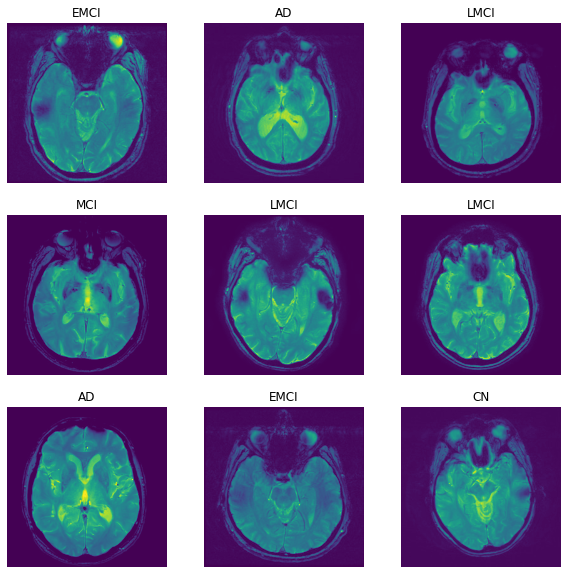

In [11]:
plt.figure(figsize=(10, 10))
i=0
for x in range(9):
    ax = plt.subplot(3, 3, i+1)
    i+=1
    plt.imshow(trainData[x])
    plt.title(trainDataLables[x])
    plt.axis("off")

In [12]:
def conv_block(filters):
    block = Sequential([
        layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D()
    ]
    )
    
    return block

In [13]:
def dense_block(units, dropout_rate):
    block = Sequential([
        layers.Dense(units, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate)
    ])
    
    return block

In [14]:
model = models.Sequential([
    layers.Conv2D(filters=16,kernel_size=7,kernel_initializer='he_uniform',activation='relu',input_shape=input_shape),
    layers.Conv2D(filters=16,kernel_size=7,kernel_initializer='he_uniform',activation='relu'),
    layers.MaxPooling2D(),


    conv_block(32),
    conv_block(64),
        
    conv_block(128),
    tf.keras.layers.Dropout(0.2),
    
    conv_block(256),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    dense_block(512, 0.5),
    dense_block(128, 0.3),
    dense_block(64, 0.1),
    layers.Dense(output_size, activation='softmax')
])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 16)      800       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 244, 244, 16)      12560     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 122, 122, 16)      0         
_________________________________________________________________
sequential (Sequential)      (None, 61, 61, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 30, 30, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 15, 15, 128)       27072     
_______________________________________

In [15]:
METRICS = [tf.keras.metrics.AUC(name='auc')]
model.compile(
        optimizer='adam',
        loss=tf.keras.losses.categorical_crossentropy,
        metrics=METRICS
    )

In [16]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [17]:
history = model.fit(
    x_train,y_train,
    validation_data=(x_val,y_val),
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS,verbose=2
)

Train on 1972 samples, validate on 493 samples
Epoch 1/5
1972/1972 - 244s - loss: 1.7517 - auc: 0.5415 - val_loss: 9.1098 - val_auc: 0.4914
Epoch 2/5
1972/1972 - 239s - loss: 1.6067 - auc: 0.5883 - val_loss: 2.2059 - val_auc: 0.5233
Epoch 3/5
1972/1972 - 240s - loss: 1.5614 - auc: 0.6229 - val_loss: 2.6477 - val_auc: 0.5223
Epoch 4/5
1972/1972 - 243s - loss: 1.5222 - auc: 0.6550 - val_loss: 2.1702 - val_auc: 0.5297
Epoch 5/5
1972/1972 - 237s - loss: 1.4807 - auc: 0.6770 - val_loss: 1.6938 - val_auc: 0.5901


In [19]:
model.save(path+"\\alzheimer_model_trained1.h5")

In [20]:
# model = models.load_model(path+r"\trained.h5")
testData=[]
testDataLables=[]
for name in class_names:
    images = [cv2.imread(file,cv2.COLOR_BGR2GRAY) for file in glob.glob(path+"\\test\\"+name+r'\*.jpg')]
    for i in images:
        i=cv2.resize(i,(256, 256))
        testData.append(np.array(i).reshape((256, 256, 1)))
        testDataLables.append(name)


testData=np.asarray(testData)
testDataLables=np.asarray(testDataLables)



testlableId=[]
for i in range(len(testDataLables)):
    for j in range(len(class_names)):
        if testDataLables[i]==class_names[j]:
            testlableId.append(j)

testLables=tf.keras.utils.to_categorical(testlableId, num_classes=len(class_names), dtype='float32')

In [21]:
model.evaluate(testData, testLables)

195/195 [==============================] - 5s 28ms/sample - loss: 1.6627 - auc: 0.6146


[1.662698063483605, 0.6145759]